This notebook provides an example of how to use the `poopy` package to access historical CSO discharge monitoring data provided by water companies.

First, we import the libraries we need.

In [1]:
from poopy.companies import ThamesWater

# To help demonstrate the package
import datetime
import os
import matplotlib.pyplot as plt

First we initiate an instance of a `WaterCompany` object. We opt to use the `ThamesWater` as an example. 

In [2]:
tw_clientID = os.getenv("TW_CLIENT_ID")
tw_clientSecret = os.getenv("TW_CLIENT_SECRET")

if tw_clientID is None or tw_clientSecret is None:
    raise ValueError(
        "Thames Water API keys are missing from the environment!\n Please set them and try again."
    )

tw = ThamesWater(tw_clientID, tw_clientSecret)

Initialising Thames Water object...
Requesting current status data from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=0
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeCurrentStatus?limit=1000&offset=1000
	No more records to fetch


Initiating a `WaterCompany` object will automatically download the current status of all the monitors. What we want to do is explore historical information for past discharges. This can either be done at the level of the individual `Monitor` or at the level of the `WaterCompany`. Lets explore the former first using the "Bourton-On-The-Water" monitor.

In [3]:
monitor = tw.active_monitors["Bourton-On-The-Water"]
monitor.get_history()

Requesting historical data for Bourton-On-The-Water from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=0&col_1=LocationName&operand_1=eq&value_1=Bourton-On-The-Water
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=1000&col_1=LocationName&operand_1=eq&value_1=Bourton-On-The-Water
	No more records to fetch
	Building history for Bourton-On-The-Water...


Above, we ran the `get_history()` method that extracts the historical data for a given monitor. This information is stored in the `Monitor` object in the `history` attribute. This is a List of `Event` objects. For example, lets see what the fifth event in the history is. Recall that an `Event` object can either be a `Discharge`, `Offline` or `NoDischarge`. 

In [4]:
fifth_event = monitor.history[4]
fifth_event.print()


        
        --------------------------------------
        Event Type: Discharging
        Site Name: Bourton-On-The-Water
        Permit Number: CTCR.2036
        OSGB Coordinates: (417620, 219070)
        Receiving Watercourse: Groundwater
        Start Time: 2023-12-28 08:00:00
        End Time: 2023-12-28 21:30:00
        Duration: 810.0 minutes
        


To visualise the history once it has been calculated we can use the `plot_history()` method. This will plot the history of the monitor as a 'barcode', the colour of the bar corresponds to the status of the event through time. Brown is a discharge, grey is offline and white is no discharge. Note that the barchart automatically goes back as far as the first recorded discharge or offline event for that monitor. 

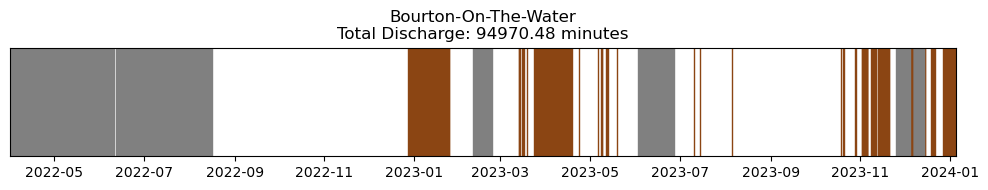

In [5]:
monitor.plot_history()

We can make it plot for a shorter period by passing a `since` parameter. For example, lets look at only the last 3 months.

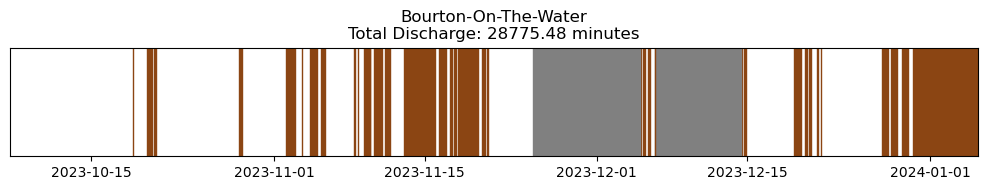

In [6]:
since_3_months = datetime.datetime.now() - datetime.timedelta(days=90) # 90 days = 3 months
monitor.plot_history(since=since_3_months)

We can print out some summary information about the total amount of discharge as follows:

In [7]:
print(f"Total discharge: {monitor.total_discharge()} minutes")
print(f"Total discharge last 12 months: {monitor.total_discharge_last_12_months()} minutes")
print(f"Total discharge last 6 months: {monitor.total_discharge_last_6_months()} minutes")
print(f"Total discharge since start of year: {monitor.total_discharge_since_start_of_year()} minutes")
print(f"Total discharge last 3 months: {monitor.total_discharge(since=since_3_months)} minutes")

Total discharge: 94970.48490005 minutes
Total discharge last 12 months: 83580.00000016668 minutes
Total discharge last 6 months: 29060.484925016666 minutes
Total discharge since start of year: 6410.4849297 minutes
Total discharge last 3 months: 28775.484931466664 minutes


If we want to calculate the history for all monitors managed by a particular water company we can do this by calling the `set_all_histories()` method on the `WaterCompany` object. This sets the `history` attribute of all the monitors in the `WaterCompany` object.

In [8]:
# This is commented out as API throws up HTTP 500 errors as of 5/1/2024! A fix is underway...
# tw.set_all_histories()

# Instead we use this slower method to set the history for each monitor...
for monitor in tw.active_monitors.values():
    print(f"Getting history for {monitor.site_name}")
    monitor.get_history()
tw._history_timestamp = datetime.datetime.now()

Getting history for (Northern) Low Level No 1 Brook Green
Requesting historical data for (Northern) Low Level No 1 Brook Green from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=0&col_1=LocationName&operand_1=eq&value_1=%28Northern%29+Low+Level+No+1+Brook+Green
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=1000&col_1=LocationName&operand_1=eq&value_1=%28Northern%29+Low+Level+No+1+Brook+Green
	No more records to fetch
	Building history for (Northern) Low Level No 1 Brook Green...
Getting history for [Coming Soon] Abbeydale Road
Requesting historical data for [Coming Soon] Abbeydale Road from Thames Water API...
	Requesting from https://prod-tw-opendata-app.uk-e1.cloudhub.io/data/STE/v1/DischargeAlerts?limit=1000&offset=0&col_1=LocationName&operand_1=eq&value_1=%5BComing+Soon%5D+Abbeydale+Road
	No more records to fetch
	Building history for [

Then, the monitor's history object can be accessed as before. For example, lets get the history for the "Marlborough" monitor.

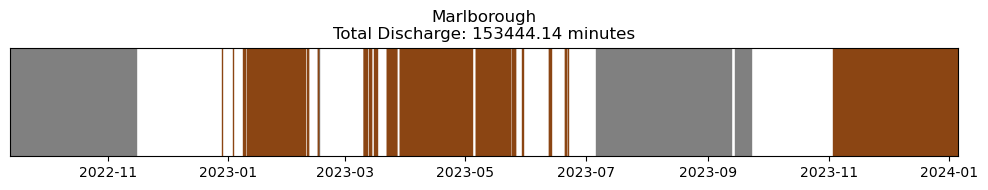

In [9]:
monitor = tw.active_monitors["Marlborough"]
monitor.plot_history()

Alternatively, we can get all of the discharge events in the form of a `pandas` dataframe using the `get_history_df()` method. This returns a dataframe that contains all the discharge events for all the monitors managed by the water company, sorted from newest to oldest start times. This dataframe can then be analysed using standard pandas methods. The columns of the dataframe are shown below:

In [10]:
df = tw.history_to_discharge_df()
print(df.columns.to_list())

Building output data-table
	Processing (Northern) Low Level No 1 Brook Green
	Processing [Coming Soon] Abbeydale Road
	Processing [Coming Soon] Alicia Avenue CSO
	Processing [Coming Soon] Alperton Lane
	Processing [Coming Soon] Banbury Rd Middleton Cheney
	Processing [Coming Soon] Bookham SPS
	Processing [Coming Soon] Boyne Avenue, Hendon
	Processing [Coming Soon] Brackner Road CSO 
	Processing [Coming Soon] Brent Cross Flyover
	Processing [Coming Soon] Brent Valley Golf Course, LB Ealing
	Processing [Coming Soon] Bridle Close, Ewell
	Processing [Coming Soon] Bucknell
	Processing [Coming Soon] Bute Street, Outside No 43 (PH)
	Processing [Coming Soon] Carlton Cres Jnc Blenheim Cres
	Processing [Coming Soon] Channelsea West Ham Lane PS 
	Processing [Coming Soon] Chigwell Road / Langston Road
	Processing [Coming Soon] Chigwell Road, Woodford Green
	Processing [Coming Soon] Chisledon Storm Tanks 
	Processing [Coming Soon] Church Road
	Processing [Coming Soon] Church Road/Brent Lodge Park (

/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:421: UserWarning: !WARNING! Event is ongoing and has no end time. Returning None.
  warnings.warn(
/home/alex/anaconda3/envs/working/lib/python3.10/site-packages/poopy/poopy.py:912: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, event._to_row()], ignore_index=True)


	Processing Arborfield
	Processing Arford
	Processing Ascot
	Processing Ash Ridge (Wokingham)
	Processing Ash Vale
	Processing Aston Le Walls
	Processing Auckland Road Storm Tanks
	Processing Avon Dassett
	Processing Avondale Rd
	Processing Aylesbury
	Processing Bakers Farm, High Wych
	Processing Bampton
	Processing Banbury
	Processing Barbers Lane
	Processing Barkway
	Processing Basingstoke
	Processing Beckley
	Processing Beckton
	Processing Beddington
	Processing Beech Hall Crescent, Walthamstow
	Processing Beenham
	Processing Beer Lane
	Processing Bell Lane Creek
	Processing Bell Wharf
	Processing Benson
	Processing Bentley
	Processing Bentsbrook Road
	Processing Berkhamsted
	Processing Bicester
	Processing Birchanger - Duck End
	Processing Bishop Stortford Main
	Processing Blacknest,Sunningdale
	Processing Bledington
	Processing Bletchingdon
	Processing Blind Mans Gate, Highclere
	Processing Bloxham
	Processing Blunsdon
	Processing Boddington
	Processing Bordon
	Processing Bourton-

This can then be saved to file using the standard Pandas methods. For example, to save it as a CSV file that can be analysed using other tools (e.g, Excel) we can do the following:

In [11]:
filename = tw.name + tw.history_timestamp.strftime("%y%m%d%H%M%S") + ".csv"
print(f"Saving history to {filename}")
df.to_csv(filename, header=True, index=False)

Saving history to ThamesWater240105105407.csv


Lets say we want to look at how CSO overflows have changed over time. Or perhaps how many monitors are online at any one time across a water companies patch. We can do this using the `get_monitor_timeseries()` method of a `WaterCompany`. This generates time series of the number of active CSOs, recently active CSOs and online monitors at 15 minute intervals (the approximate frequency of the data). Lets generate this data from the start of 2022.

In [12]:
since = datetime.datetime(2022, 1, 1)
monitor_series = tw.get_monitor_timeseries(since=since)

Processing (Northern) Low Level No 1 Brook Green
Processing [Coming Soon] Abbeydale Road
Monitor [Coming Soon] Abbeydale Road has no recorded events
Processing [Coming Soon] Alicia Avenue CSO
Monitor [Coming Soon] Alicia Avenue CSO has no recorded events
Processing [Coming Soon] Alperton Lane
Monitor [Coming Soon] Alperton Lane has no recorded events
Processing [Coming Soon] Banbury Rd Middleton Cheney
Monitor [Coming Soon] Banbury Rd Middleton Cheney has no recorded events
Processing [Coming Soon] Bookham SPS
Monitor [Coming Soon] Bookham SPS has no recorded events
Processing [Coming Soon] Boyne Avenue, Hendon
Monitor [Coming Soon] Boyne Avenue, Hendon has no recorded events
Processing [Coming Soon] Brackner Road CSO 
Monitor [Coming Soon] Brackner Road CSO  has no recorded events
Processing [Coming Soon] Brent Cross Flyover
Monitor [Coming Soon] Brent Cross Flyover has no recorded events
Processing [Coming Soon] Brent Valley Golf Course, LB Ealing
Monitor [Coming Soon] Brent Valley G

Now lets plot the results.

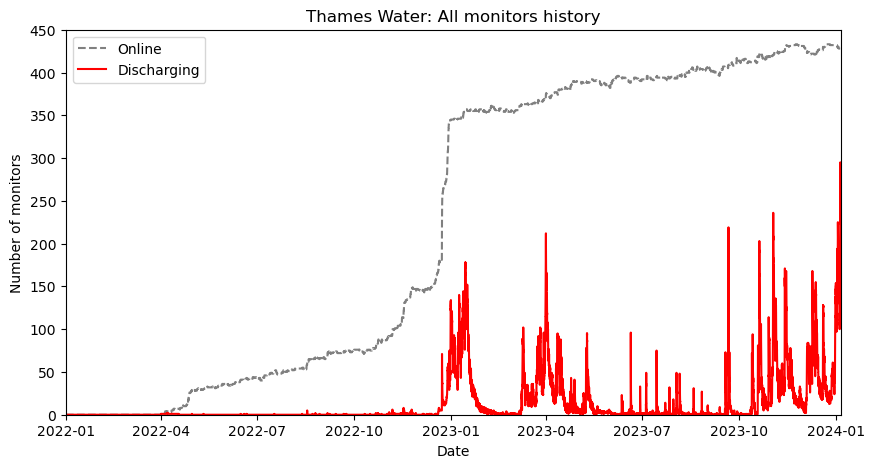

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_online"],
    c="grey",
    label="Online",
    linestyle="dashed",
)
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_discharging"],
    c="red",
    label="Discharging",
)
plt.ylabel("Number of monitors")
plt.xlabel("Date")
# Set the xlimits to be the min and max of the datetime column
plt.xlim(monitor_series["datetime"].min(), monitor_series["datetime"].max())
plt.ylim(0, 450)
plt.title("Thames Water: All monitors history")
plt.legend()
plt.show()

We can see that the number of monitors where we have active data increased significantly at the start of 2023. Since then, the coverage has got gradually better but the number of active monitors has remained fairly constant. As ecpected there are more CSOs active during the winter months. To get a more averaged (less 'spiky') view of the data we can look at those which have been active in the last 48 hours (shown below) but the overall picture is the same.

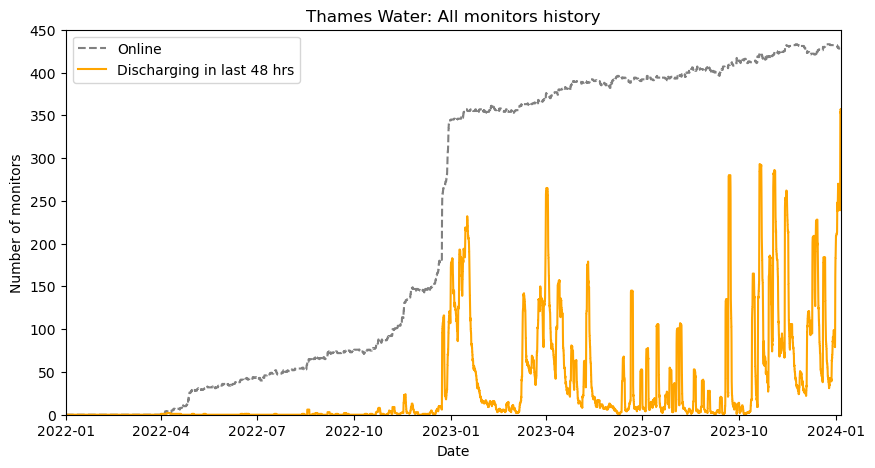

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_online"],
    c="grey",
    label="Online",
    linestyle="dashed",
)
plt.plot(
    monitor_series["datetime"],
    monitor_series["number_recently_discharging"],
    c="orange",
    label="Discharging in last 48 hrs",
)
plt.ylabel("Number of monitors")
plt.xlabel("Date")
# Set the xlimits to be the min and max of the datetime column
plt.xlim(monitor_series["datetime"].min(), monitor_series["datetime"].max())
plt.ylim(0, 450)
plt.title("Thames Water: All monitors history")
plt.legend()
plt.show()

Finally we can see how easy it is to generate some simple statistics about the data. For example:

In [15]:
number_online_now = monitor_series["number_online"].iloc[-1]
print(f"Number of monitors online now: {number_online_now}")
number_discharging_now = monitor_series["number_discharging"].iloc[-1]
print(f"Number of monitors discharging now: {number_discharging_now}")
print(f"Proportion of monitors discharging now: {number_discharging_now / number_online_now * 100:.2f}%")
number_recently_discharging_now = monitor_series["number_recently_discharging"].iloc[-1]
print(f"Number of monitors discharging in last 48 hrs: {number_recently_discharging_now}")
print(f"Proportion of monitors discharging in last 48 hrs: {number_recently_discharging_now / number_online_now * 100:.2f}%")

Number of monitors online now: 429
Number of monitors discharging now: 223
Proportion of monitors discharging now: 51.98%
Number of monitors discharging in last 48 hrs: 357
Proportion of monitors discharging in last 48 hrs: 83.22%
